# Imports

In [86]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
import seaborn as sns
import numpy as np
import datetime as dt

# Data

In [87]:
bike_df = pd.read_csv('raw_data/bike_loans.csv', sep=';').drop(columns=['Importe', 
                                                                        'DescripcionImporte', 
                                                                        'operario'])
bike_df['Fecha_Prestamo'] = bike_df['Fecha_Prestamo'].astype('datetime64[ns]')
bike_df['Fecha_Devolucion'] = bike_df['Fecha_Devolucion'].astype('datetime64[ns]')
bike_df = bike_df.dropna()

bike_df.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Num_Bici_Hist                     float64
dtype: object

# Evolutions

In [88]:
bike_df['year'] = bike_df.Fecha_Prestamo.dt.year

## Unique bikes

In [89]:
bike_df.head(2)

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,year
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,929.0,2017
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,1679.0,2017


In [90]:
# calculate the change of bikes
evolution_bikes = {}
for year in sorted(bike_df.year.unique())[::-1]:
    df_filter = bike_df[bike_df.year == year]
    df_filter_prev = bike_df[bike_df.year == year-1]
    bikes_ = df_filter.Id_Tag_Bicicleta.unique()
    bikes_prev = df_filter_prev.Id_Tag_Bicicleta.unique()
    count_up = len([bike for bike in bikes_ if bike not in bikes_prev])
    count_down = -len([bike for bike in bikes_prev if bike not in bikes_])
    evolution_bikes[year] = {'loss': count_down, 'win': count_up}

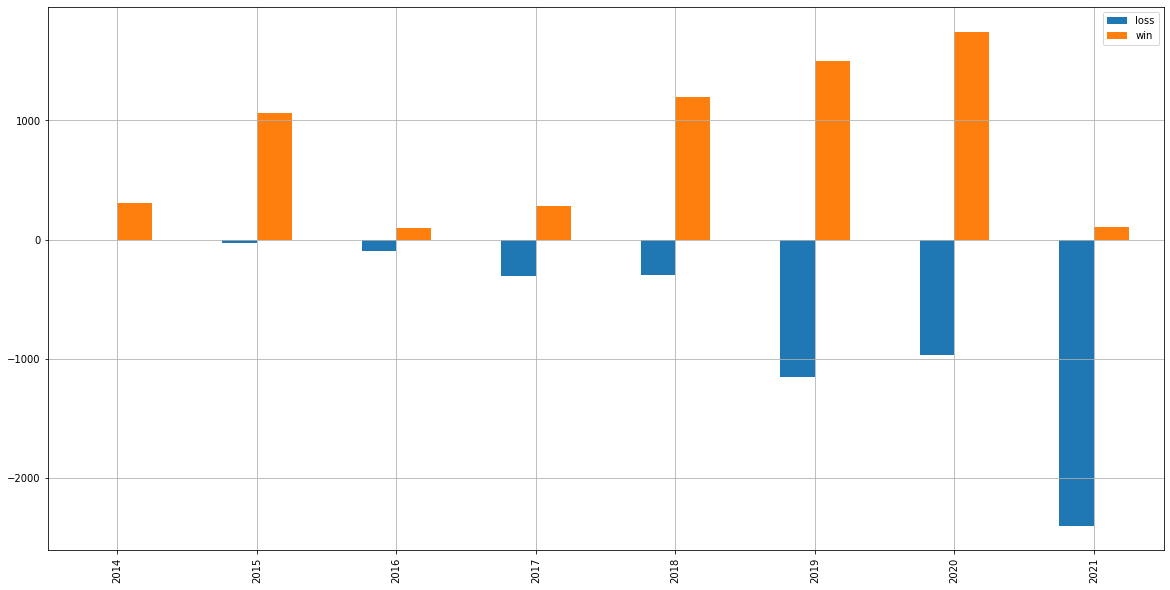

In [91]:
pd.DataFrame(evolution_bikes).T.sort_index().plot(kind='bar', figsize=(20,10))
plt.grid()

**Note**<br>
we can see that a lot of bikes stopped appearing in 2021. The highest investments have been made in 2020.

## Evolution bike routes

In [92]:
bike_df['routes'] = bike_df.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)
                                  

In [93]:
# calculate change of routes
evolution_routes = {}
for year in sorted(bike_df.year.unique())[::-1]:
    df_filter = bike_df[bike_df.year == year]
    df_filter_prev = bike_df[bike_df.year == year-1]
    routes_ = df_filter.routes.unique()
    routes_prev = df_filter_prev.routes.unique()
    count_up = len([route for route in routes_ if route not in routes_prev])
    count_down = -len([route for route in routes_prev if route not in routes_])
    evolution_routes[year] = {'loss': count_down, 'win': count_up}

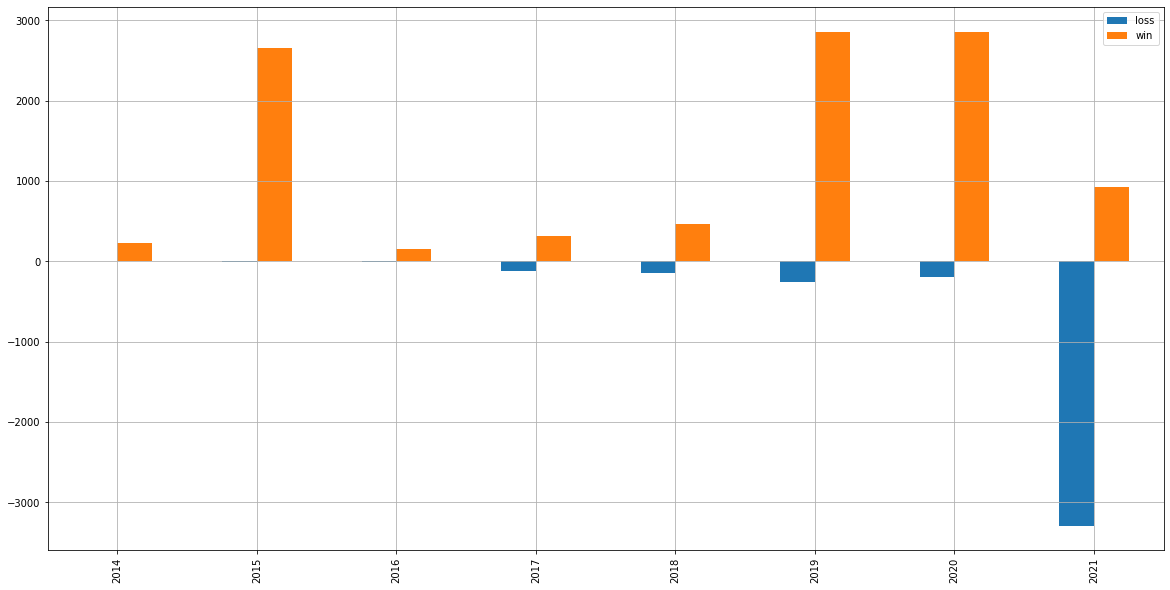

In [94]:
pd.DataFrame(evolution_routes).T.sort_index().plot(kind='bar', figsize=(20,10))
plt.grid()

**Note**<br>
In 2019 and 2020 a lot of new routes were explored by the bike users.

## Evolution rentals total

In [95]:
# calculate evolution of rentals
evolution_rentals = {}
for year in sorted(bike_df.year.unique()):
    df_filter = bike_df[bike_df.year == year]
    count = df_filter.Id_Historico_Prestamo.count()
    evolution_rentals[year] = count

In [96]:
evolution_rentals_df = pd.DataFrame.from_dict(evolution_rentals, orient='index').rename(columns={0:'count'})

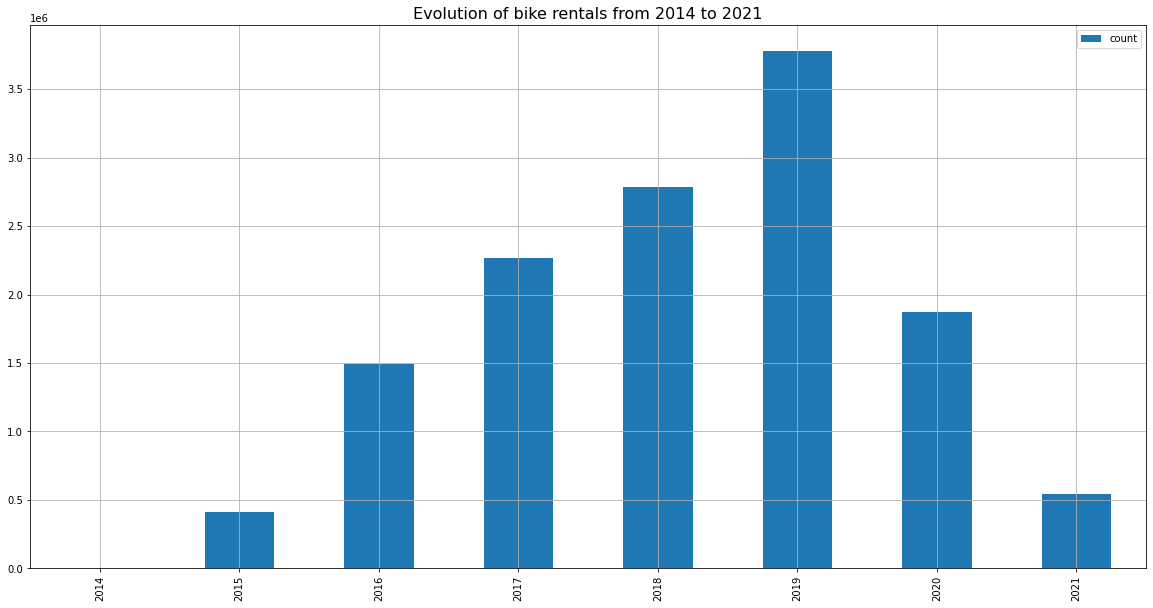

In [97]:
evolution_rentals_df.plot(kind='bar', figsize=(20,10))
plt.grid()
plt.title("Evolution of bike rentals from 2014 to 2021", size=16)
plt.show()

**Note**<br>
There was a big plummet of bike usage in 2020 (due to covid). 2021 is not representative since the records stop on the **20/04/2021**

## rental times

In [113]:
bike_df['timespan_min'] = (bike_df.Fecha_Devolucion - bike_df.Fecha_Prestamo).dt.seconds/60

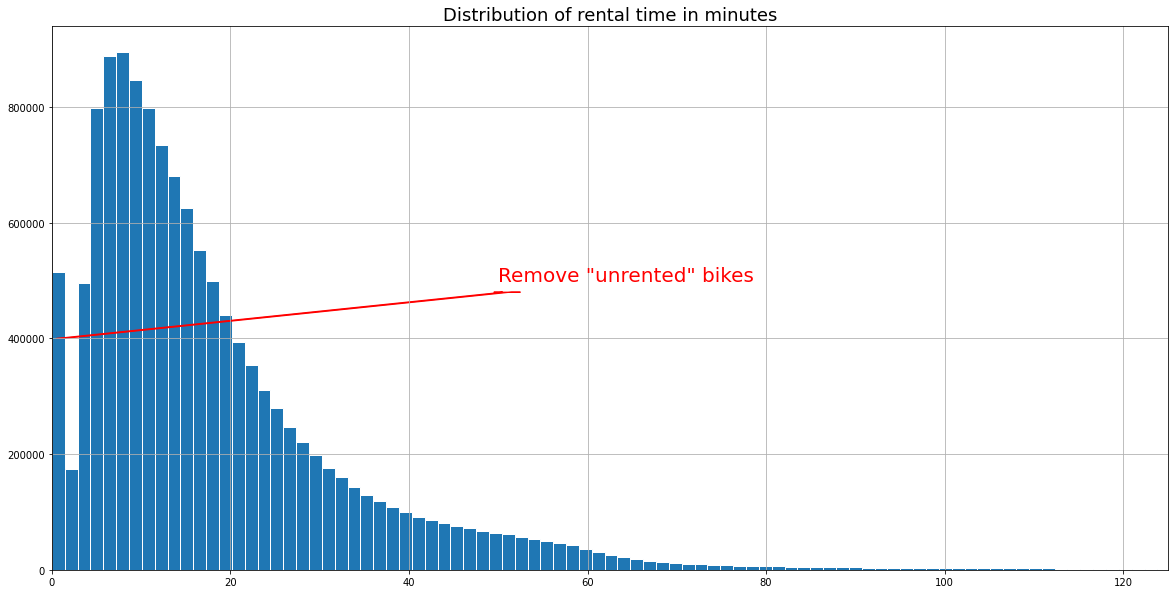

In [155]:
bike_df.timespan_min.hist(bins=1000, figsize=(20,10), edgecolor='white')
plt.xlim(0,125)
plt.title('Distribution of rental time in minutes', size=18)
plt.text(50, 500000, s='Remove "unrented" bikes', c='r', rotation='horizontal', fontsize=20)
plt.arrow(1, 400000, 50, 80000, color='r', width=1)
plt.show()